In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
import neurokit2 as nk
from ipyfilechooser import FileChooser
from IPython.display import display, HTML
from datetime import datetime, timezone
from pyedflib.highlevel import read_edf
from wrangle import *
%matplotlib widget

In [3]:
required_files = [ 'synched_data.pkl.gz',
                  'event_times.pkl.gz'
                  ]
dataDirectory = "C:/home/Sessions/P009/"
print("Current directory is:", dataDirectory)
missing_files = [f for f in required_files if f not in os.listdir(dataDirectory)]
existing_files = [f for f in os.listdir(dataDirectory) if f in required_files]
if dataDirectory:
    print(f"Directory being checked: {dataDirectory}")
    if not missing_files:
        print("✓ All required files are present!")
    else:
        print("\nMissing files:")
        for file in missing_files:
            print(f"✗ {file}")
        print(f"\nFound files:")
        for file in existing_files:
            print(f"• {file}")

try:
    synched_df = pd.read_pickle(os.path.join(dataDirectory, "synched_data.pkl.gz"), compression="gzip")
    if synched_df is not None:
        print("Biosignal Data Successfully Loaded")
    else:
        print("Error loading biosignal data")
except Exception as e:
    print(f"Error loading biosignal data: {e}")

try:
    events_df = pd.read_pickle(os.path.join(dataDirectory, "event_times.pkl.gz"), compression="gzip")
    if events_df is not None:
        print("Test Timing Data Successfully Loaded")
    else:
        print("Error loading timing data")
except Exception as e:
    print(f"Error loading timing data: {e}")

Current directory is: C:/home/Sessions/P009/
Directory being checked: C:/home/Sessions/P009/
✓ All required files are present!
Biosignal Data Successfully Loaded
Test Timing Data Successfully Loaded


## ECG Processing

Dropdown(description='Select Test Segment:', index=5, options=('survey', 'cycle_cal', 'matb_train', 'cycle', '…

Dropdown(description='Select Cleaning Method:', options=('neurokit', 'pantompkins1985', 'hamilton2002', 'elgen…

Button(description='Process ECG', icon='check', style=ButtonStyle(), tooltip='Click to process the selected se…

Output()

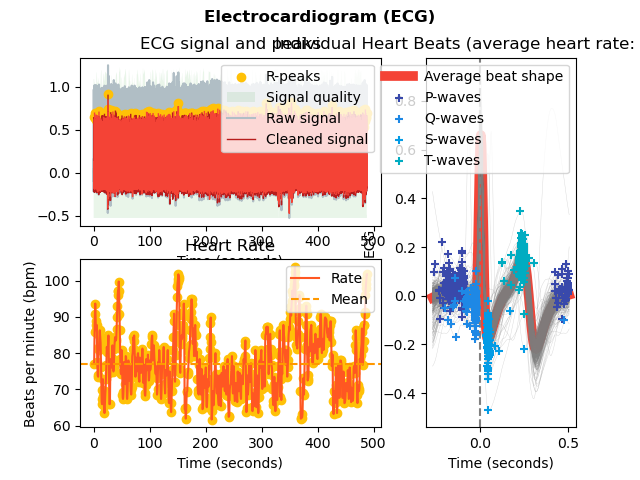

In [4]:
fs = 256

# Create ECG widgets
segment_dropdown = widgets.Dropdown(
    options=events_df['name'].tolist(),
    value='baseline',
    description='Select Test Segment:',
    disabled=False,
)

process_method_dropdown = widgets.Dropdown(
    options=['neurokit', 'pantompkins1985', 'hamilton2002', 'elgendi2010', 'engzeemod2012'],
    value='neurokit',
    description="Select Cleaning Method:",
    disabled=False,
)

process_button = widgets.Button(
    description='Process ECG',
    disabled=False,
    button_style='',
    tooltip='Click to process the selected segment',
    icon='check'
)

output = widgets.Output()

def process_ecg():
    """Process ECG and store results in global variables"""
    global ecg_signals, ecg_info, analyzed_ecg_df
    
    selected_interval = events_df[events_df['name'] == segment_dropdown.value].iloc[0]
    start_time = selected_interval['start']
    end_time = selected_interval['end']
    
    start_idx = int((start_time - events_df['start'].min()).total_seconds() * fs)
    end_idx = int((end_time - events_df['start'].min()).total_seconds() * fs)
    
    ecg_segment = synched_df['ECG'][start_idx:end_idx]
    
    ecg_signals, ecg_info = nk.ecg_process(
        ecg_segment, 
        sampling_rate=fs, 
        method=process_method_dropdown.value
    )
    
    analyzed_ecg_df = nk.ecg_analyze(ecg_signals, sampling_rate=fs)
    
    with output:
        output.clear_output()
        display(analyzed_ecg_df)
        nk.ecg_plot(ecg_signals, ecg_info)

def on_ecg_button_click(b):
    process_ecg()

process_button.on_click(on_ecg_button_click)

display(segment_dropdown, process_method_dropdown, process_button, output)

# EDA Processing

Dropdown(description='Select Test Segment:', index=5, options=('survey', 'cycle_cal', 'matb_train', 'cycle', '…

Dropdown(description='Select Cleaning Method:', index=1, options=('biosppy', 'neurokit'), value='neurokit')

Button(description='Process EDA', icon='check', style=ButtonStyle(), tooltip='Click to process the selected se…

Output()

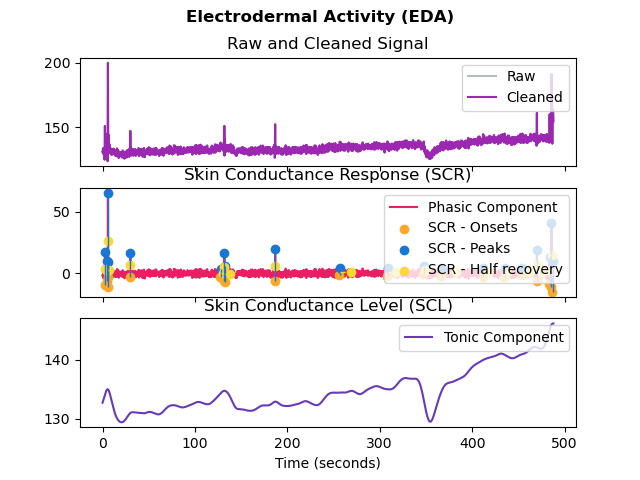

In [6]:
eda_signals = None
eda_info = None
analyzed_eda_df = None

# Create EDA widgets
eda_segment_dropdown = widgets.Dropdown(
    options=events_df['name'].tolist(),
    value='baseline',
    description='Select Test Segment:',
    disabled=False,
)

eda_process_method_dropdown = widgets.Dropdown(
    options=["biosppy", "neurokit"],
    value='neurokit',
    description="Select Cleaning Method:",
    disabled=False,
)

eda_process_button = widgets.Button(
    description='Process EDA',
    disabled=False,
    button_style='',
    tooltip='Click to process the selected segment',
    icon='check'
)

eda_output = widgets.Output()

def process_eda():
    """Process EDA and store results in global variables"""
    global eda_signals, eda_info, analyzed_eda_df
    
    selected_interval = events_df[events_df['name'] == eda_segment_dropdown.value].iloc[0]
    start_time = selected_interval['start']
    end_time = selected_interval['end']
    
    start_idx = int((start_time - events_df['start'].min()).total_seconds() * fs)
    end_idx = int((end_time - events_df['start'].min()).total_seconds() * fs)
    
    eda_segment = synched_df['EDA'][start_idx:end_idx]

    eda_segment = eda_segment * 1000
    
    eda_signals, eda_info = nk.eda_process(
        eda_segment, 
        sampling_rate=fs, 
        method=eda_process_method_dropdown.value
    )
    
    analyzed_eda_df = nk.eda_analyze(eda_signals, sampling_rate=fs)
    
    with eda_output:
        eda_output.clear_output()
        display(analyzed_eda_df)
        nk.eda_plot(eda_signals, eda_info)

def on_eda_button_click(b):
    process_eda()

eda_process_button.on_click(on_eda_button_click)

# Display EDA widgets
display(eda_segment_dropdown, eda_process_method_dropdown, eda_process_button, eda_output)

# PPG Processing

Dropdown(description='Select Test Segment:', index=5, options=('survey', 'cycle_cal', 'matb_train', 'cycle', '…

Dropdown(description='Select Processing Method:', options=('elgendi',), value='elgendi')

Dropdown(description='Select Quality Method:', options=('templatematch', 'disimilarity'), value='templatematch…

Button(description='Process PPG', icon='check', style=ButtonStyle(), tooltip='Click to process the selected se…

Output()

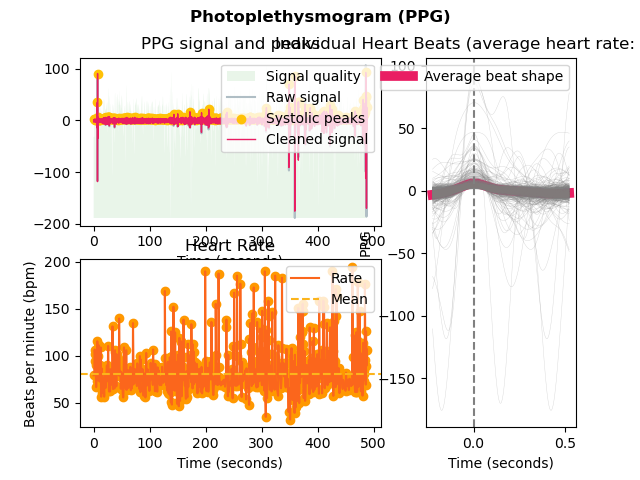

In [8]:
ppg_signals = None
ppg_info = None
analyzed_ppg_df = None

ppg_segment_dropdown = widgets.Dropdown(
    options=events_df['name'].tolist(),
    value='baseline',
    description='Select Test Segment:',
    disabled=False,
)

ppg_process_method_dropdown = widgets.Dropdown(
    options=["elgendi"],
    value='elgendi',
    description="Select Processing Method:",
    disabled=False,
)

ppg_quality_method_dropdown = widgets.Dropdown(
    options=["templatematch", "disimilarity"],
    value='templatematch',
    description="Select Quality Method:",
    disabled=False,
)

ppg_process_button = widgets.Button(
    description='Process PPG',
    disabled=False,
    button_style='',
    tooltip='Click to process the selected segment',
    icon='check'
)

ppg_output = widgets.Output()

def process_ppg():
    """Process PPG and store results in global variables"""
    global ppg_signals, ppg_info, analyzed_ppg_df
    
    selected_interval = events_df[events_df['name'] == ppg_segment_dropdown.value].iloc[0]
    start_time = selected_interval['start']
    end_time = selected_interval['end']
    
    start_idx = int((start_time - events_df['start'].min()).total_seconds() * fs)
    end_idx = int((end_time - events_df['start'].min()).total_seconds() * fs)
    
    ppg_segment = synched_df['PPG'][start_idx:end_idx]
    
    ppg_signals, ppg_info = nk.ppg_process(
        ppg_segment, 
        sampling_rate=fs, 
        method=ppg_process_method_dropdown.value,
        method_quality=ppg_quality_method_dropdown.value
    )
    
    analyzed_ppg_df = nk.ppg_analyze(ppg_signals, sampling_rate=fs)
    
    with ppg_output:
        ppg_output.clear_output()
        display(analyzed_ppg_df)
        nk.ppg_plot(ppg_signals, ppg_info)

def on_ppg_button_click(b):
    process_ppg()

ppg_process_button.on_click(on_ppg_button_click)

# Display PPG widgets
display(ppg_segment_dropdown, ppg_process_method_dropdown, ppg_quality_method_dropdown, ppg_process_button, ppg_output)

# Respiration Processing

Dropdown(description='Select Test Segment:', index=5, options=('survey', 'cycle_cal', 'matb_train', 'cycle', '…

Dropdown(description='Select Processing Method:', options=('khodadad2018', 'biosppy'), value='khodadad2018')

Dropdown(description='Select RVT Method:', options=('harrison2021', 'birn2006', 'power2020'), value='harrison2…

Button(description='Process RSP', icon='check', style=ButtonStyle(), tooltip='Click to process the selected se…

Output()

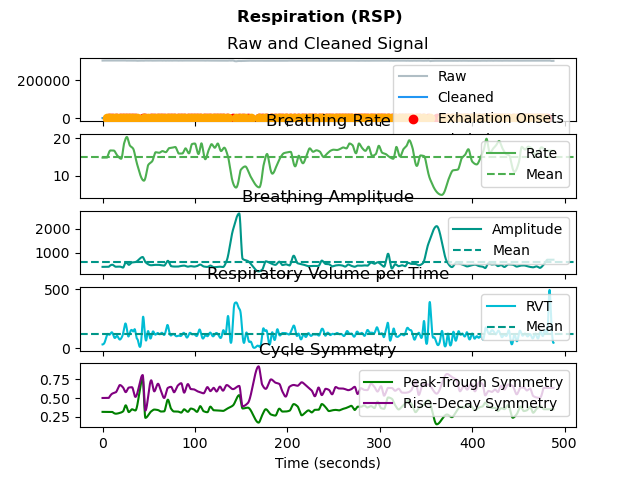

In [10]:
# Initialize global variables for RSP
rsp_signals = None
rsp_info = None
analyzed_rsp_df = None

# Create RSP widgets
rsp_segment_dropdown = widgets.Dropdown(
    options=events_df['name'].tolist(),
    value='baseline',
    description='Select Test Segment:',
    disabled=False,
)

rsp_process_method_dropdown = widgets.Dropdown(
    options=["khodadad2018", "biosppy"],
    value='khodadad2018',
    description="Select Processing Method:",
    disabled=False,
)

rsp_rvt_method_dropdown = widgets.Dropdown(
    options=["harrison2021", "birn2006", "power2020"],
    value='harrison2021',
    description="Select RVT Method:",
    disabled=False,
)

rsp_process_button = widgets.Button(
    description='Process RSP',
    disabled=False,
    button_style='',
    tooltip='Click to process the selected segment',
    icon='check'
)

rsp_output = widgets.Output()

def process_rsp():
    """Process RSP and store results in global variables"""
    global rsp_signals, rsp_info, analyzed_rsp_df
    
    selected_interval = events_df[events_df['name'] == rsp_segment_dropdown.value].iloc[0]
    start_time = selected_interval['start']
    end_time = selected_interval['end']
    
    start_idx = int((start_time - events_df['start'].min()).total_seconds() * fs)
    end_idx = int((end_time - events_df['start'].min()).total_seconds() * fs)
    
    rsp_segment = synched_df['Combined Respiration'][start_idx:end_idx]
    
    rsp_signals, rsp_info = nk.rsp_process(
        rsp_segment, 
        sampling_rate=fs, 
        method=rsp_process_method_dropdown.value,
        method_rvt=rsp_rvt_method_dropdown.value
    )
    
    analyzed_rsp_df = nk.rsp_analyze(rsp_signals, sampling_rate=fs)
    
    with rsp_output:
        rsp_output.clear_output()
        display(analyzed_rsp_df)
        nk.rsp_plot(rsp_signals, rsp_info)

def on_rsp_button_click(b):
    process_rsp()

rsp_process_button.on_click(on_rsp_button_click)

# Display RSP widgets
display(rsp_segment_dropdown, rsp_process_method_dropdown, rsp_rvt_method_dropdown, rsp_process_button, rsp_output)

# HRV Metrics 

Dropdown(description='Select Test Segment:', index=5, options=('survey', 'cycle_cal', 'matb_train', 'cycle', '…

Button(description='Process HRV', icon='check', style=ButtonStyle(), tooltip='Click to process the selected se…

Output()

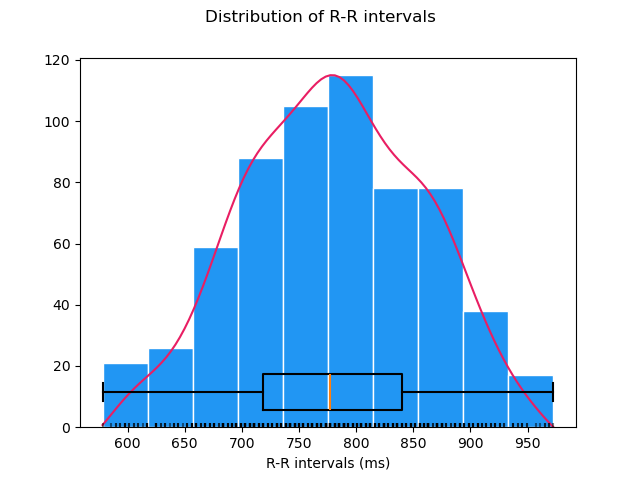

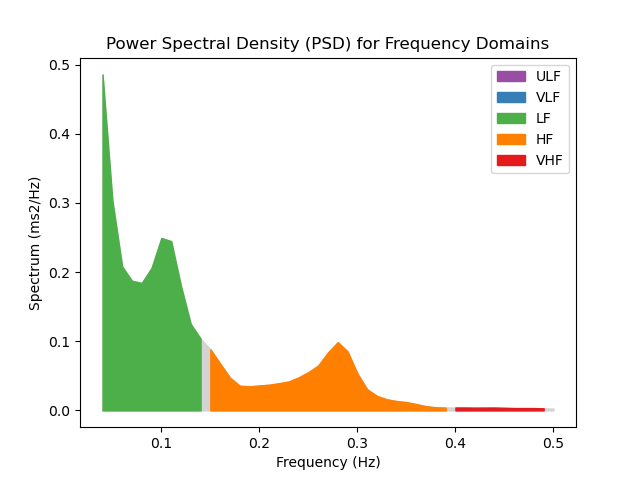

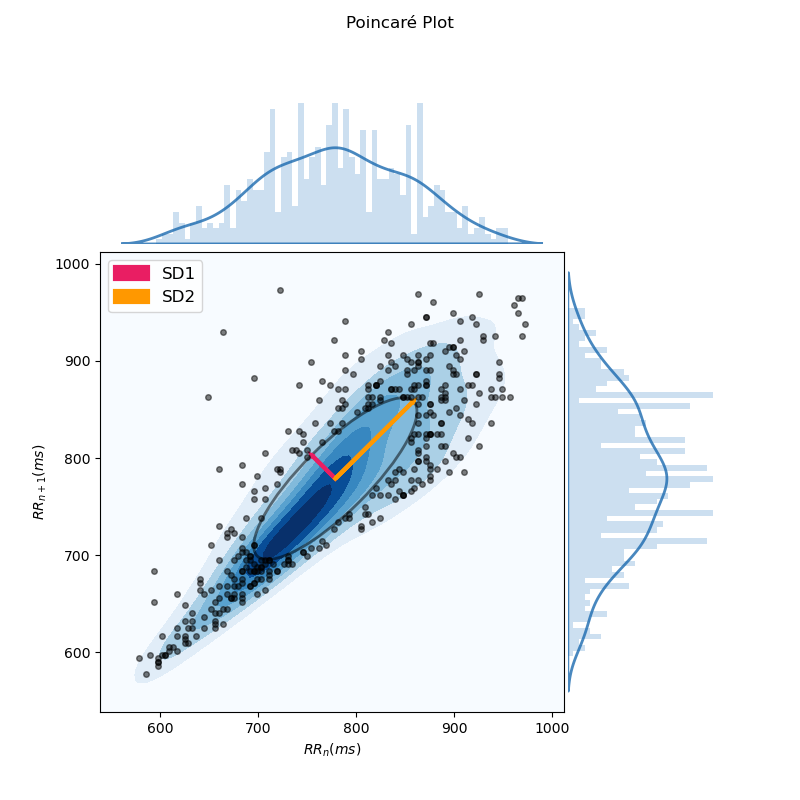

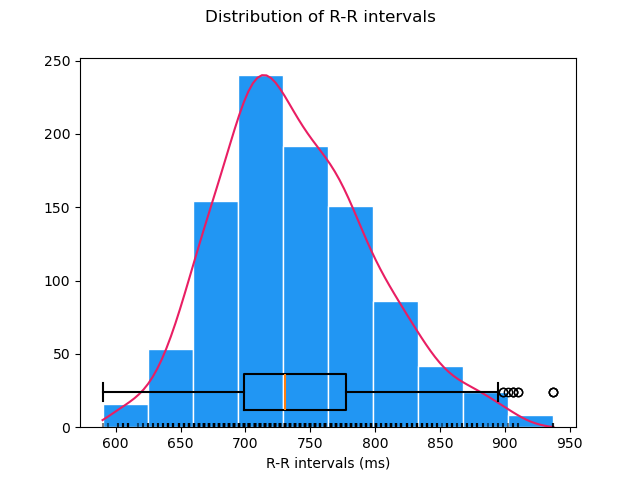

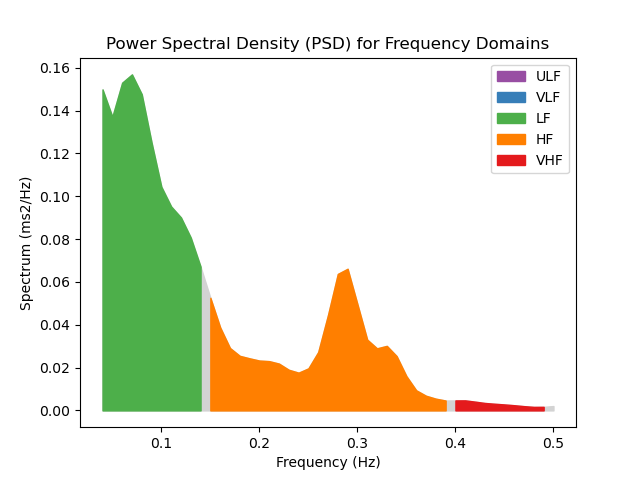

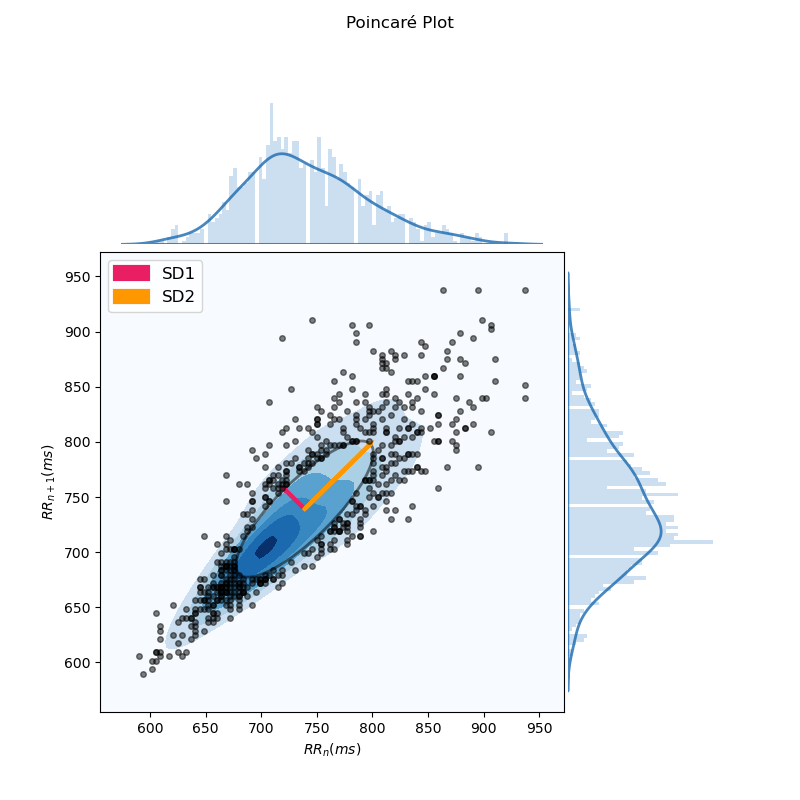

In [14]:
# Initialize global variables for HRV
hrv_time_results = None
hrv_frequency_results = None
hrv_nonlinear_results = None

# Create HRV widgets
hrv_segment_dropdown = widgets.Dropdown(
    options=events_df['name'].tolist(),
    value='baseline',
    description='Select Test Segment:',
    disabled=False,
)

hrv_process_button = widgets.Button(
    description='Process HRV',
    disabled=False,
    button_style='',
    tooltip='Click to process the selected segment',
    icon='check'
)

hrv_output = widgets.Output()

def process_hrv():
    """Process HRV and store results in global variables"""
    global hrv_time_results, hrv_frequency_results, hrv_nonlinear_results
    
    selected_interval = events_df[events_df['name'] == hrv_segment_dropdown.value].iloc[0]
    start_time = selected_interval['start']
    end_time = selected_interval['end']
    
    start_idx = int((start_time - events_df['start'].min()).total_seconds() * fs)
    end_idx = int((end_time - events_df['start'].min()).total_seconds() * fs)
    
    ecg_segment = synched_df['ECG'][start_idx:end_idx]
    
    ecg_signals, ecg_info = nk.ecg_process(
        ecg_segment, 
        sampling_rate=fs, 
        method='neurokit'
    )
    
    peaks = ecg_info['ECG_R_Peaks']
    
    hrv_time_results = nk.hrv_time(peaks, sampling_rate=fs, show=True)
    hrv_frequency_results = nk.hrv_frequency(peaks, sampling_rate=fs, show=True)
    hrv_nonlinear_results = nk.hrv_nonlinear(peaks, sampling_rate=fs, show=True)
    
    with hrv_output:
        hrv_output.clear_output()
        display(hrv_time_results)
        display(hrv_frequency_results)
        display(hrv_nonlinear_results)

def on_hrv_button_click(b):
    process_hrv()

hrv_process_button.on_click(on_hrv_button_click)

# Display HRV widgets
display(hrv_segment_dropdown, hrv_process_button, hrv_output)

# Change Point Detection

In [ ]:
prominent_features = {
        "ECG LF/HF": hrv_frequency_results["HRV_LFHF"],
        "ECG #ibis": hrv_time_results["HRV_NN"],
        "ECG RMSSD": hrv_time_results["HRV_RMSSD"],
        "ECG Mean HR": hrv_time_results["HRV_MeanNN"],
        "PPG LF/HF": ppg_hrv_frequency_results["HRV_LFHF"],
        "PTT": ptt_results["PTT"],
        "eda": eda_results["EDA"]
    }


changepoints_results = {}
    for feature_name, feature_data in prominent_features.items():
        changepoints_results[feature_name] = nk.signal_changepoints(feature_data, change='meanvar')